In [1]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import decode_predictions, preprocess_input
from keras.utils import load_img, img_to_array
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils import normalize

from cam_generator import ScoreCamSaliency

In [2]:
model = tf.keras.applications.vgg16.VGG16(weights="imagenet")
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def show_image(ary, act_map):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(act_map, cmap="viridis")
    ax[0].axis("off")
    ax[1].imshow(ary/np.max(ary))
    ax[1].axis("off")
    plt.show()

In [4]:
def GetGradCAMPlusPlus(cls_index, img, model):
  def loss(output):
    return (output[0][cls_index])
  def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
  gradcam = GradcamPlusPlus(model,model_modifier=model_modifier,clone=False)
  cam = gradcam(loss, img, penultimate_layer=-1)
  cam = normalize(cam)
  return cam

def GetSmoothGrad(cls_index, img, model):
  def loss(output):
    return (output[0][cls_index])
  def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
  saliency = Saliency(model,model_modifier=model_modifier,clone=False)
  cam = saliency(loss, img, smooth_samples=20, smooth_noise=0.20)
  cam = normalize(cam)
  return cam

In [5]:
with open('imagenet_class_index.json') as f:
    data = json.load(f)
    class_names = np.array([row['ja'] for row in data])

In [19]:
layer_name = "block5_conv3"
img_file = "images/gordon.jpg"
img = load_img(img_file, target_size=(224, 224))
ary = img_to_array(img)
copy_ary = ary.copy()
pre_ary = preprocess_input(copy_ary)

In [14]:
pred = model.predict(pre_ary[np.newaxis, :, :, :])[0]
top3_classes = pred.argsort()[-10:][::-1]
n = top3_classes[0]

for name, score in zip(class_names[top3_classes], pred[top3_classes]):
    print('{}: {:.2%}'.format(name, score))

1/1 [==============================] - 0s 101ms/step
ゴードンセッター: 99.33%
コッカースパニエル: 0.35%
サセックススパニエル: 0.16%
イングリッシュセッター: 0.14%
アイリッシュセッター: 0.02%
クランバー: 0.01%
黒と黄褐色の猟犬: 0.01%
アイルランドのウォータースパニエル: 0.00%
イングリッシュスプリンガー: 0.00%
ウェルシュスプリンガースパニエル: 0.00%


16/16 [==============================] - 32s 2s/step


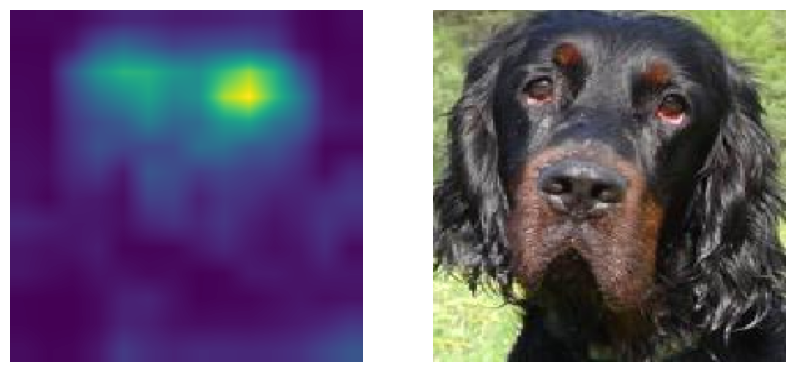

In [15]:
score_cam = ScoreCamSaliency(model, n, layer_name)
act_map, y = score_cam(pre_ary[np.newaxis, :, :, :])
show_image(ary, act_map[0])

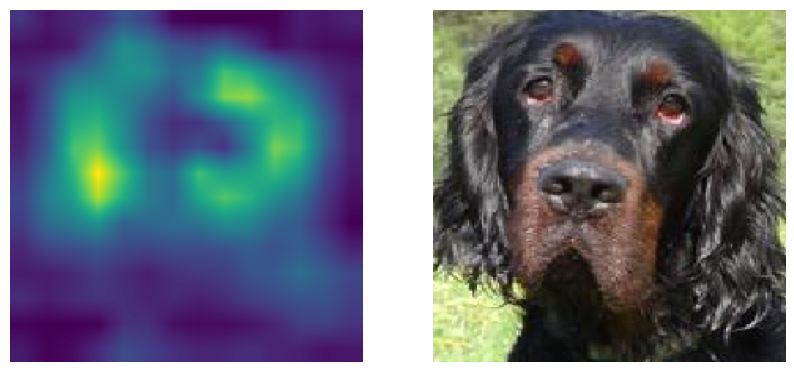

In [21]:
grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

with tf.GradientTape() as tape:
    target_layer_output, preds = grad_model(pre_ary[np.newaxis, :, :, :])
    class_channel = preds[:, n]

grads = tape.gradient(class_channel, target_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = target_layer_output[0] @ pooled_grads[...,tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = cv2.resize(heatmap.numpy(), ary.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
show_image(ary, heatmap)

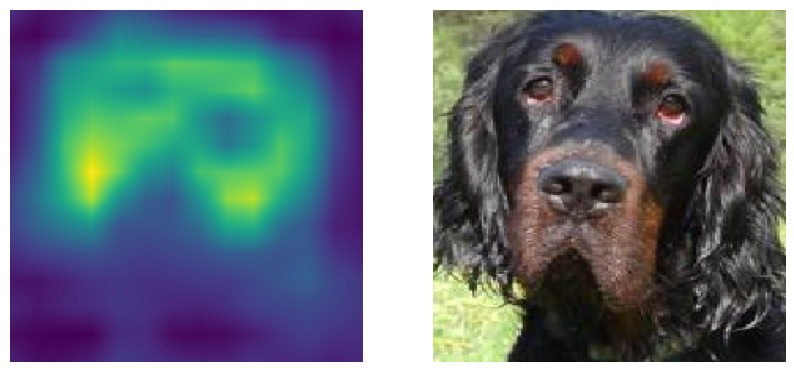

In [17]:
act_map = GetGradCAMPlusPlus(n, pre_ary[np.newaxis, :, :, :], model)
show_image(ary, act_map[0])

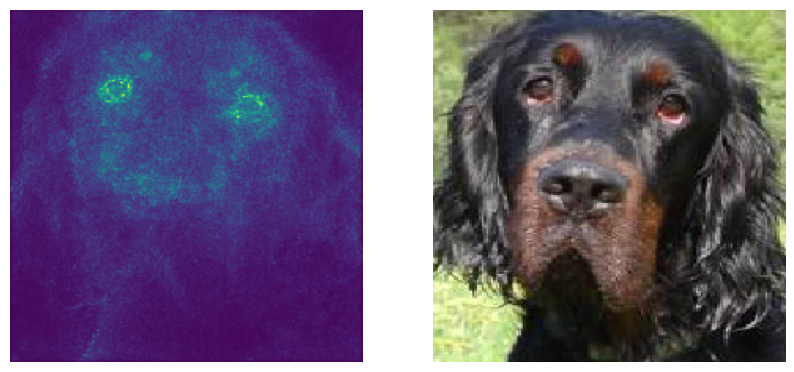

In [18]:
act_map = GetSmoothGrad(n, pre_ary[np.newaxis, :, :, :], model)
show_image(ary, act_map[0])

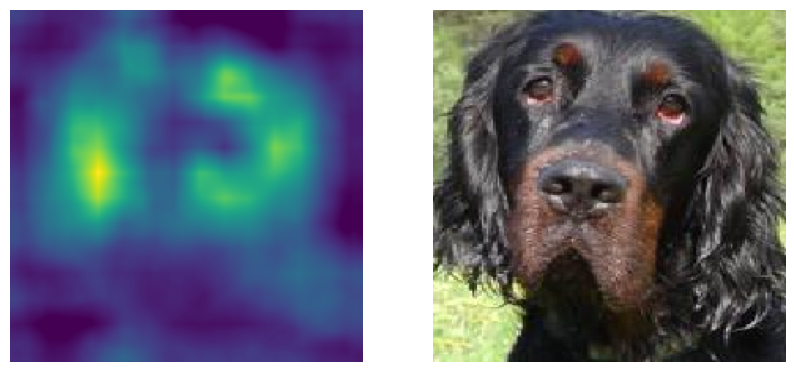

In [22]:
heatmaps = []
for i in range(1, 6):
    if i < 3:
        layer_name = f"block{i}_conv2"
    else:
        layer_name = f"block{i}_conv3"
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        target_layer_output, preds = grad_model(pre_ary[np.newaxis, :, :, :])
        class_channel = preds[:, n]

    grads = tape.gradient(class_channel, target_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = target_layer_output[0] @ pooled_grads[...,tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), ary.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    heatmaps.append(heatmap)


heatmap = np.sum(np.array(heatmaps), axis=0)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
show_image(ary, heatmap)